<a href="https://colab.research.google.com/github/haldonmez/mnist-digit-recognizer/blob/main/MNIST_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch import nn

import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

print(f"Pytorch version: {torch.__version__}\ntorchvision version:{torchvision.__version__}")

Pytorch version: 2.1.0+cu121
torchvision version:0.16.0+cu121


In [4]:
data = "/content/data"
train_data = datasets.MNIST(
    root=data,
    train= True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = datasets.MNIST(
    root=data,
    train=False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 160413735.90it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 117265918.51it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45641615.28it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5315437.71it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selecte randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 1875 iterations with the batch size of 32.
For testing data there is 313 iterations with the batch size of 32.


For this model we will begin implementing GPU and the non-linearity functions such as RELU.

In [6]:
# Setup GPU as a available device.

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"This model currently runs on {device}")

# T4 GPU must be activated in Google Colab to add GPU.

This model currently runs on cuda


In [7]:
from torch import nn
class DigitRecognizerMNISTV2(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [8]:
torch.manual_seed(42)

model_1 = DigitRecognizerMNISTV2(input_shape=784,
                                 hidden_units=10,
                                 output_shape=len(train_data.classes)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [9]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [11]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

This time we will create our model training and testing as a function so we can use it later...

In [12]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.5f}, Test accuracy is:{test_acc:.2f}%")

In [13]:
torch.manual_seed(42)
from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_part(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func
    )
    test_part(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss is:0.45602, Train accuracy is:86.75%
Test loss is:0.26454, Test accuracy is:92.02%
Epoch: 1
---------
Train loss is:0.27140, Train accuracy is:92.00%
Test loss is:0.24936, Test accuracy is:92.90%
Epoch: 2
---------
Train loss is:0.24100, Train accuracy is:92.94%
Test loss is:0.23292, Test accuracy is:93.17%
Epoch: 3
---------
Train loss is:0.22615, Train accuracy is:93.28%
Test loss is:0.22074, Test accuracy is:93.56%
Epoch: 4
---------
Train loss is:0.21686, Train accuracy is:93.59%
Test loss is:0.20750, Test accuracy is:93.97%
Train time on cuda: 51.551 seconds


With the use of simple non-linearity function ReLU we increased the prediction accuracy rate to about 93%.
Good rates but still not good enough.
I will continue to create a model_2 to learn and implement an actual CNN network.

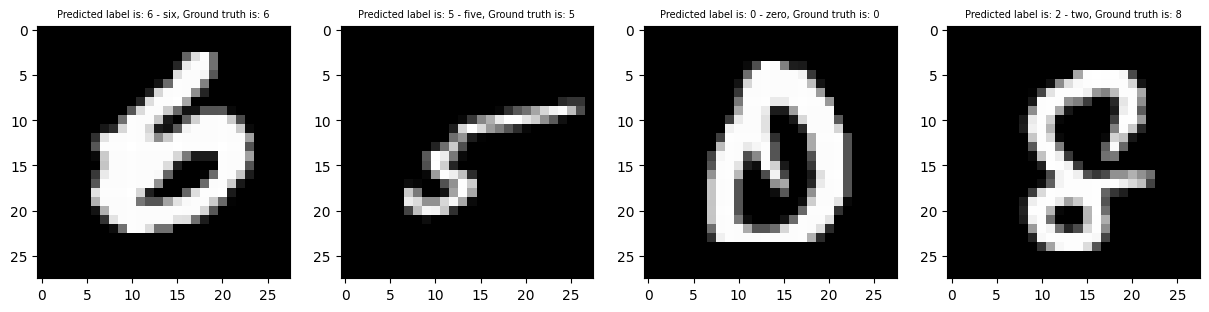

In [21]:
import random
import matplotlib.pyplot as plt

# Getting a random image and a label from the ground truth. Using test_dataloader because our model
# hasn't seen the test_dataloader data yet.
image1, label1 = test_dataloader.dataset[random.randint(0, len(test_dataloader.dataset) - 1)]
image2, label2 = test_dataloader.dataset[random.randint(0, len(test_dataloader.dataset) - 1)]
image3, label3 = test_dataloader.dataset[random.randint(0, len(test_dataloader.dataset) - 1)]
image4, label4 = test_dataloader.dataset[random.randint(0, len(test_dataloader.dataset) - 1)]

image1 = image1.to(device)
image2 = image2.to(device)
image3 = image3.to(device)
image4 = image4.to(device)

# Putting the random image selected above to our mode and getting the output shape.
model_1.eval()
with torch.inference_mode():
    prediction1 = model_1(image1)
    prediction2 = model_1(image2)
    prediction3 = model_1(image3)
    prediction4 = model_1(image4)

# Getting our real prediction using argmax to reach the highest index.
predicted_label1 = prediction1.argmax(dim=1).item()
predicted_label2 = prediction2.argmax(dim=1).item()
predicted_label3 = prediction3.argmax(dim=1).item()
predicted_label4 = prediction4.argmax(dim=1).item()

image1 = image1.to("cpu")
image2 = image2.to("cpu")
image3 = image3.to("cpu")
image4 = image4.to("cpu")
# Create a figure with four subplots with the selected sizes.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 35))

# Display the images
ax1.imshow(image1.squeeze(), cmap="gray")
ax2.imshow(image2.squeeze(), cmap="gray")
ax3.imshow(image3.squeeze(), cmap="gray")
ax4.imshow(image4.squeeze(), cmap="gray")

# Set the titles with the predicted labels
ax1.set_title(f"Predicted label is: {train_data.classes[predicted_label1]}, Ground truth is: {label1}", fontsize=7)
ax2.set_title(f"Predicted label is: {train_data.classes[predicted_label2]}, Ground truth is: {label2}", fontsize=7)
ax3.set_title(f"Predicted label is: {train_data.classes[predicted_label3]}, Ground truth is: {label3}", fontsize=7)
ax4.set_title(f"Predicted label is: {train_data.classes[predicted_label4]}, Ground truth is: {label4}", fontsize=7)

plt.show()
